In [1]:
import numpy as np
from math import sqrt

import datetime
import csv
import matplotlib.pyplot as plt

from pyspark.mllib.clustering import KMeans, KMeansModel

In [2]:
with open('data/detroit.csv') as f:
    csv_file = csv.reader(f)
    next(csv_file)
    crime_list = []
    for row in csv_file:
        crime_list.append(row)

In [3]:
data = []
for row in crime_list:
    crime_date = datetime.datetime.strptime(row[2], '%m/%d/%Y').date()
    crime_pos  = np.array([float(row[-2]), float(row[-1])])
    crime_type = [x.strip() for x in row[3].split(' - ')]
    data.append([crime_date, crime_pos, crime_type])

In [4]:
data_rdd = sc.parallelize(data)
histogram_year_rdd = data_rdd.map(lambda x: (x[0].month, 1)).reduceByKey(lambda x, y: x + y).sortByKey()
year_count = histogram_year_rdd.collect()
histogram_category_rdd = data_rdd.flatMap(lambda x: [(category, 1) for category in x[2]]).reduceByKey(lambda x, y: x + y).sortByKey()
category_count = histogram_category_rdd.collect()

<Container object of 12 artists>

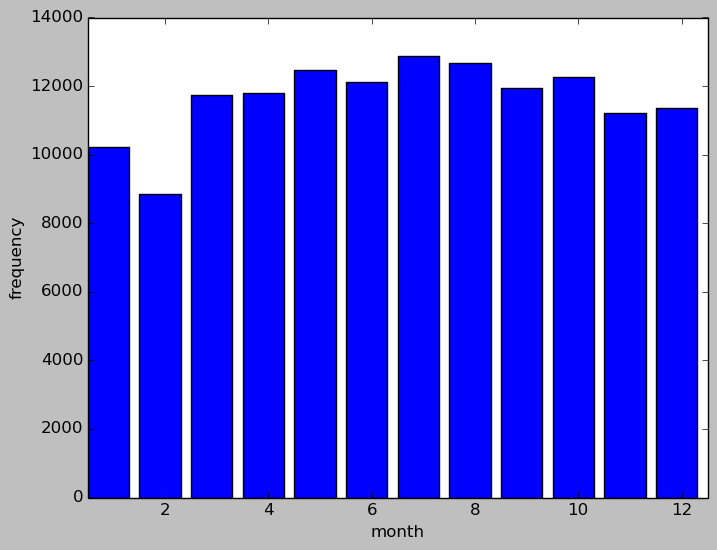

In [5]:
month = [x[0] - 0.5 for x in year_count]
freq = [x[1] for x in year_count]
plt.xlabel('month')
plt.ylabel('frequency')
plt.xlim([0.5,12.5])
plt.bar(month, freq)

<Container object of 449 artists>

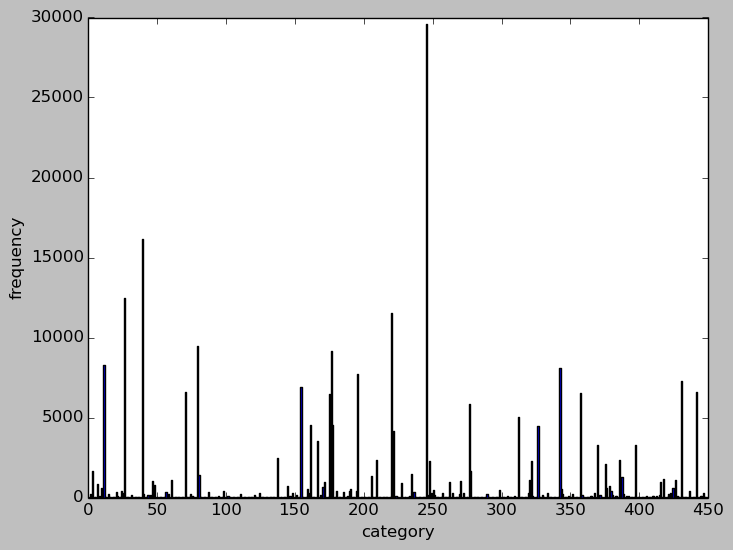

In [6]:
category = [x for x in category_count]
freq = [x[1] for x in category_count]
plt.xlabel('category')
plt.ylabel('frequency')
plt.bar(range(len(category)),freq)

In [7]:
def category_filter(entry, category_types):
    for category in category_types:
        for entry_category in entry:
            if category in entry_category:
                return True
    return False

In [19]:
def cluster(date_range, category_types, num_clusters):
    #Label data
    filtered_rdd = data_rdd.filter(lambda x: x[0].month in date_range and category_filter(x[2], category_types))
    pos_rdd= filtered_rdd.map(lambda x: x[1])
    clusters = KMeans.train(pos_rdd, num_clusters, maxIterations=100, initializationMode="random")
    label_rdd = filtered_rdd.map(lambda x: [x[1], clusters.centers[clusters.predict(x[1])]]).collect()
    
    #Cluster and distribution
    return label_rdd, clusters.centers

In [20]:
def sse(point, clusters):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

In [21]:
#WSSSE = pos_rdd.map(lambda point: sse(point)).reduce(lambda x, y: x + y)
#print("Within Set Sum of Squared Error = " + str(WSSSE))

In [22]:
label, centers = cluster([1, 2], ['MURDER'], 10)

In [23]:
label

[[array([ 42.4313, -83.1895]), array([ 42.410875, -83.199275])],
 [array([ 42.3005, -83.1012]), array([ 42.3482625, -83.08575  ])],
 [array([ 42.3927, -82.983 ]), array([ 42.405025, -82.954975])],
 [array([ 42.409 , -83.1362]), array([ 42.38990667, -83.14857333])],
 [array([ 42.4089, -83.136 ]), array([ 42.38990667, -83.14857333])],
 [array([ 42.436 , -83.1005]), array([ 42.38990667, -83.14857333])],
 [array([ 42.4346, -83.1559]), array([ 42.38990667, -83.14857333])],
 [array([ 42.3557, -83.0148]), array([ 42.377675, -83.020275])],
 [array([ 42.4308, -82.9875]), array([ 42.43562857, -82.97392857])],
 [array([ 42.3881, -83.2281]), array([ 42.3764  , -83.226925])],
 [array([ 42.4192, -83.1394]), array([ 42.38990667, -83.14857333])],
 [array([ 42.3841, -83.2517]), array([ 42.3764  , -83.226925])],
 [array([ 42.3755, -83.074 ]), array([ 42.3482625, -83.08575  ])],
 [array([ 42.4051, -82.9677]), array([ 42.405025, -82.954975])],
 [array([ 42.3584, -83.1318]), array([ 42.38990667, -83.148573